# "RNA-seq data analysis"

## Imports

In [2]:
import numpy as np
import pandas as pd
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from statsmodels.robust.scale import mad
import seaborn as sns
from pathlib import Path
%matplotlib inline
sns.set_style('ticks')

## Introduction

In the assignment you will use data on gene expression and annotation of samples with cancer originated in Adrenal glands. Data were obtained from 6 different projects (7 cohorts). The goal is to explore the data, combine datasets in metacohort, harmonise it, and perform analysis with clustering data into four Adrenocortical Carcinoma (ACC) expressoin subtypes using corresponding gene signatures submited in zhang et al. 2016 (doi: 10.1016/j.ccell.2016.04.002).Finally, perform survival analisys based on clustering results and predict patient survival with each subtype of adrenal cancer.


---

В задании вам будут даны экспрессии генов и аннотации пациентов с раком надпочечников (Adrenal glands) из 7 когорт (6 проектов). Задача состоит в том чтобы исследовать экпрессионные данные и аннотацию, объеденить эти когорты в метакогорту, гармонизировать ее и сделать кластерный анализ - выделить экспрессионные подтипы на основе генных сигнатур, которые опубликованны в zhang et al. 2016 (doi: 10.1016/j.ccell.2016.04.002). На основе полученных кластеров посторить кривые Каплана-Майера и предсказать выживаемость пациентов с разными подтипами рака надпочесников.

## Description of some columns in annotation
<br><b>Ki67</b> - The prolifiration score based on Ki67 protein. The expression of Ki67 is strongly associated with tumor cell proliferation and growth, and is widely used in routine pathological investigation as a proliferation marker. The nuclear protein Ki67 (pKi67) is an established prognostic and predictive indicator for the assessment of biopsies from patients with cancer.<br>
<b>Weiss_score</b> - The Weiss score is prognostic factor for tumors of the adrenal cortex. <br>
<b>Purity</b> - a fraction of tumor tissue in a bulk sample. There are fractions of tumor tissue and normal tissue in each bulk sample.<br>
<b>Ploidy</b> - an average ploidy of all chromosomes over genome.

## Task №1 (0 points)
Read gene expression data and sample annotation (there is nothing special to do in this task, just run cells below).

---

Прочитайте экспрессионные данные и аннтацию (тут ничего самим делать не надо просто запустите ячейки)

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials # Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# reading expressions

datasets_drive_id = {
'GSE33371' : '1lBf74e_SLGIfrmmDWkO2DJAQlqiaJojv',    # GPL570 platform
'GSE19750_1' : '184cbgRbT3A__Nql6oXVlew7-UDXmFRLZ',  # GPL570 platform, batch 1
'GSE19750_2' : '1QCLliXnmcava4M37n9ZtMLJIbxZ8cxUr',  # GPL570 platform, batch 2
'GSE90713' : '1zVNq6_HJyjvzA4RI9wJytcY16jOJiLVo',    # GPL15207 platform
'ACC_TCGA' : '1YgGHY83A_wdx5123zVQOeLdtGbNBoQB3',    # RNA-seq, classic PolyA RNA enreachment protocol
'GSE76019' : '18MeT_SeVR649851m1XlfNLS7gOC6dwz4',    # GPL13158 platform
'PMC9066577' : '1jToWuYq1sgHeLHoDqPnH8ibURnA9Uns6'   # RNA-seq, 3MACE, subtype of PolyA rna enreachment protocol
}

datasets = datasets_drive_id.keys()
expression_file_names = {ds:'{}_expr.tsv'.format(ds) for ds in datasets}

expressions = dict()
for key, value in datasets_drive_id.items():
  downloaded = drive.CreateFile({'id' : value})
  downloaded.GetContentFile(expression_file_names[key])
  expressions[key] = pd.read_csv(expression_file_names[key], index_col = 0,sep='\t').T

# reading annotation

annotation_drive_id = '1zukJtDDm8XGRgv-dayr_Log3m65sYi2a'
annotation_file_name = 'annotation.csv'

downloaded = drive.CreateFile({'id' : annotation_drive_id})
downloaded.GetContentFile(annotation_file_name)
annotation = pd.read_csv(annotation_file_name, index_col = 0)

## Task №2 (0.5 point)

Explore the annotation. Briefly describe the data (columns) that are presented in the annotation. What diagnoses are represented in the annotation? Provide a short description of each unique item in diagnosis column. How many patients with each diagnosis are listed in the annotation? Patients with what stage of cancer are the most in the annotation? Plot purity distibution ('Purity' column).

---
Исследуйте аннотацию. В общих словах опишите какие данные там представленны. Пациенты с какими диагнозами собраны в этих когортах? Сколько пациентов с каждым из диагнозов? Пациентов в какой стадии рака больше всего? Постройте гистограмму распределения Purity.


In [5]:
annotation.head()

,Patient,type,Cohort,Diagnosis,Gender,Age,beta_catenin_status,Clinical_characteristics,Stage,Weiss_score,...,OS_FLAG,PFS,PFS_FLAG,DFS,DFS_FLAG,ploidy,purity,Resection_status,Ki67,Sample_store_method
Sample,,,,,,,,,,,,,,,,,,,,,
GSM825367,Normal Adrenal Cortex 006 [NC],RNA,GSE33371,Normal,F,71,unknown,Adrenalectomy for metastatic lung carcinoma,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825368,Normal Adrenal Cortex 063 [NC],RNA,GSE33371,Normal,F,58,unknown,Adrenalectomy for ACA; Conn's syndrome,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825369,Normal Adrenal Cortex 069 [NC],RNA,GSE33371,Normal,M,71,unknown,Adrenalectomy for renal cell carcinoma,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825370,Normal Adrenal Cortex 076 [NC],RNA,GSE33371,Normal,M,44,unknown,Adrenalectomy for ACA; Conn's syndrome,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM825371,Normal Adrenal Cortex 083 [NC],RNA,GSE33371,Normal,F,32,unknown,Adrenalectomy for ACA,not applicable,not applicable,...,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
annotation.columns

Index(['Patient', 'type', 'Cohort', 'Diagnosis', 'Gender', 'Age',
       'beta_catenin_status', 'Clinical_characteristics', 'Stage',
       'Weiss_score', 'contact_name', 'contact_institute', 'geo_accession',
       'platform_id', 'Time_treatment', 'Androgens_secretion',
       'Estrogens_secretion', 'Aldosterone_secretion', 'Cortisol_secretion',
       'Histological_type', 'OS', 'OS_FLAG', 'PFS', 'PFS_FLAG', 'DFS',
       'DFS_FLAG', 'ploidy', 'purity', 'Resection_status', 'Ki67',
       'Sample_store_method'],
      dtype='object')

In [7]:
annotation['Diagnosis'].value_counts()

Diagnosis
Adrenocortical_Carcinoma             335
Adrenocortical_Adenoma                65
Normal                                19
Uncertain malignant potential ACT      5
Name: count, dtype: int64

In [8]:
annotation['Stage'].value_counts()

Stage
II                123
I                  76
III                57
IV                 52
not applicable     32
Unknown            16
Name: count, dtype: int64

In [9]:
annotation['Cohort'].value_counts()

Cohort
PMC9066577    139
ACC_TCGA       76
GSE33371       65
GSE90713       62
GSE76019       34
GSE19750_2     25
GSE19750_1     23
Name: count, dtype: int64

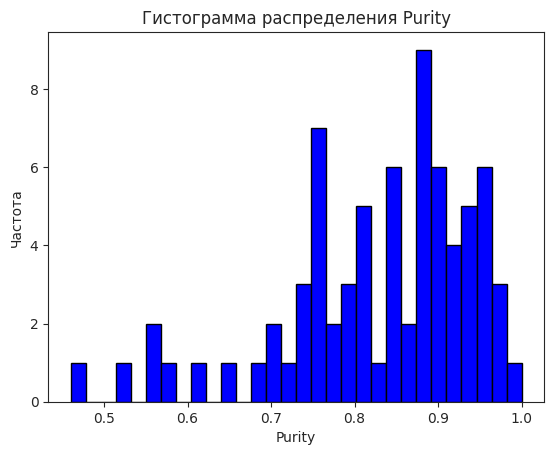

In [10]:
import matplotlib.pyplot as plt

plt.hist(annotation['purity'], bins = 30, color='b', edgecolor = 'black')

plt.xlabel('Purity')
plt.ylabel('Частота')
plt.title('Гистограмма распределения Purity')

plt.show()

**Вывод:**

Представлены характеристики пациентов, включая возраст, пол, диагноз и стадию рака, а также биоинформационные данные, такие как плоидность, чистота, статус резекции, Ki67 и метод хранения образца.

Среди диагнозов преобладают случаи аденомы надпочечников (335 образцов), затем карцинома надпочечников (65 образцов), нормальные образцы (19) и образцы с неопределенным злокачественным потенциалом (5).

Большинство пациентов находятся на второй стадии рака (123).


## Task №3 (1 point)

Check if there is a statistically significant relationship between the patient's gender (Gender) and the Cortisol secretion level (Cortisol_secretion). The last one indicates whether the patient has an increased expression of cortisol. Take only samples for which there is information about the patient's gender ('F or 'M') and cortisol overexpression is noted ('Yes' or 'No').

---
Проверьте есть ли статистически значимая взаимосвязь между полом пациента (Gender) и переменной Cortisol_secretion, в которой отмечено замечена ли повышенная экспрессия кортизола у пациента. Для анализа берите только образцы для которых есть информация о поле пациента ('F или 'M') и повышена ли экспрессия кортизола ('Yes' или 'No')


In [11]:
from scipy.stats import chi2_contingency

In [12]:
# Фильтрация данных для анализа
filtered_df = annotation[(annotation['Gender'].isin(['F', 'M'])) & (annotation['Cortisol_secretion'].isin(['Yes', 'No']))]

# Создание таблицы сопряженности
contingency_table = pd.crosstab(filtered_df['Gender'], filtered_df['Cortisol_secretion'])

# Применение критерия хи-квадрат и вывод результатов
def chi_square_test(table):
    chi2, p, _, _ = chi2_contingency(table)
    print("Хи-квадрат статистика:", round(chi2, 3))
    print("p-value:", round(p, 3))
    if p < 0.05:
        print("Есть статистически значимая взаимосвязь между Gender и Cortisol_secretion.")
    else:
        print("Нет статистически значимой взаимосвязи между Gender и Cortisol_secretion.")

# Применение критерия хи-квадрат и вывод результатов
chi_square_test(contingency_table)

Хи-квадрат статистика: 3.112
p-value: 0.078
Нет статистически значимой взаимосвязи между Gender и Cortisol_secretion.


## Task №4 (1 point)

Transform each expression dataset as follows: log2(TPM+1). Exclude samples that are not in the annotation. Plot the gene expression distribution of each cohort by averaging the expressions (use sns.distplot). Print the number of genes in each cohort, the number of samples in each cohort.

---
Прологарифмируйте датасеты согласно формуле log2(TPM+1). Уберите образцы из датасетов с эксперссией для которые не встречаются в аннотации. Постройте распределение экспресии генов каждой из когорт усреднив экспрессии (можно использовать sns.distplot), выведите число генов в каждой когорте, число образцов в каждой когорте.


Число генов в Cohort GSE33371: 24442
Число образцов в Cohort GSE33371: 65
Число генов в Cohort GSE19750_1: 24442
Число образцов в Cohort GSE19750_1: 23
Число генов в Cohort GSE19750_2: 24442
Число образцов в Cohort GSE19750_2: 25
Число генов в Cohort GSE90713: 20151
Число образцов в Cohort GSE90713: 62
Число генов в Cohort ACC_TCGA: 20062
Число образцов в Cohort ACC_TCGA: 76
Число генов в Cohort GSE76019: 20940
Число образцов в Cohort GSE76019: 34
Число генов в Cohort PMC9066577: 17450
Число образцов в Cohort PMC9066577: 139


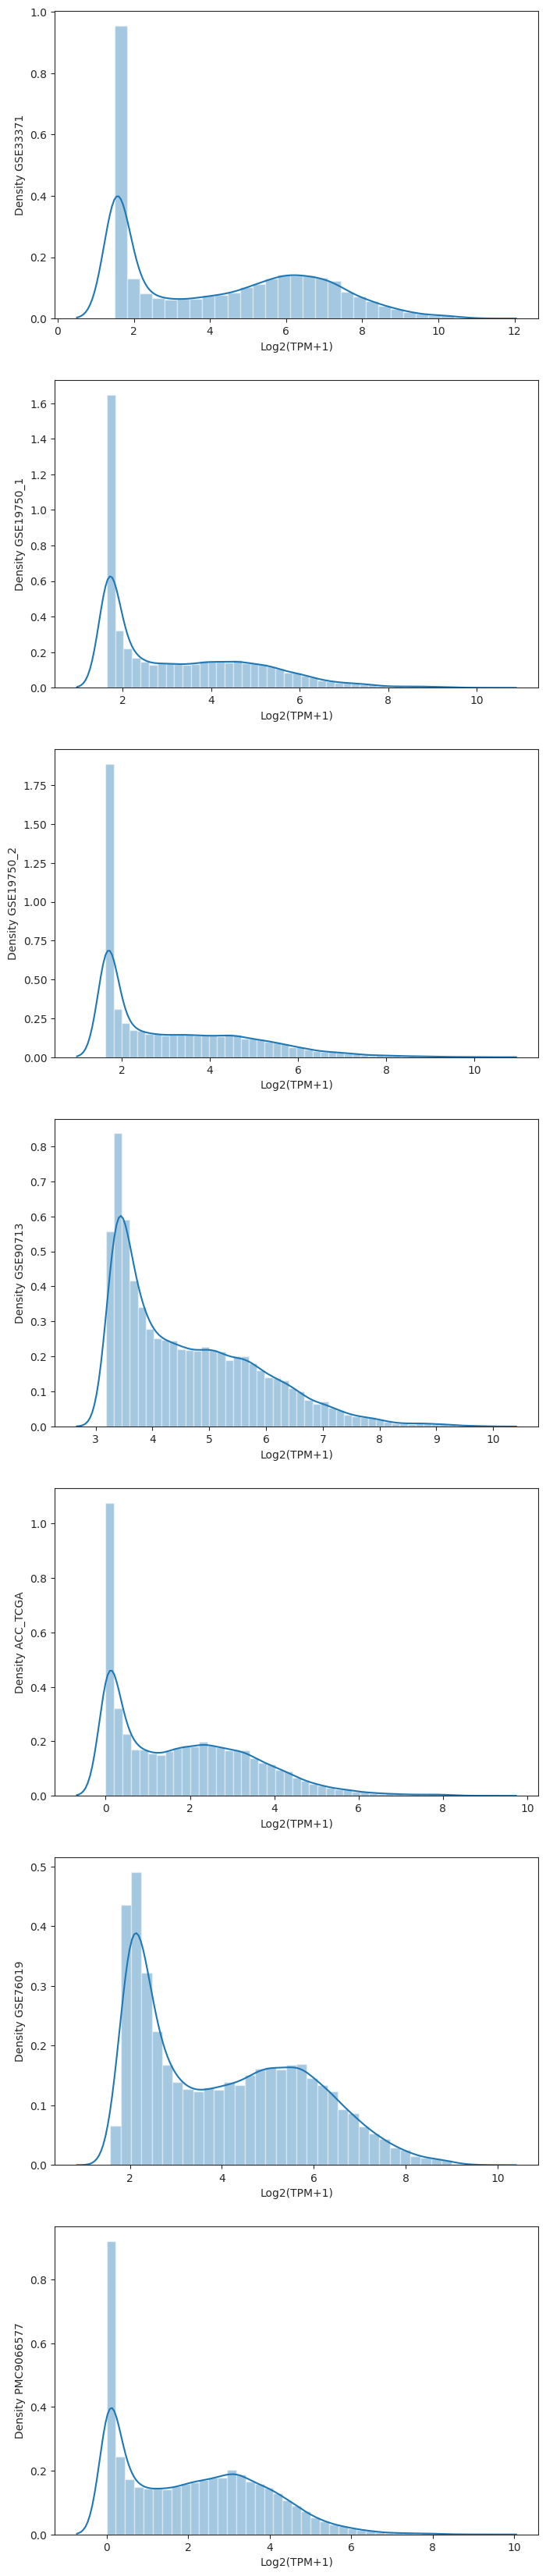

In [17]:
new_expressions_data = {}
cohort_index = 1

import warnings

warnings.filterwarnings('ignore')

annotation_indices = set(annotation.index)

def process_cohort_data(cohort_key, cohort_index, i):

    expression_indices = set(expressions[cohort_key].index)
    common_indices = expression_indices.intersection(annotation_indices)
    expressions[cohort_key] = expressions[cohort_key].loc[list(common_indices)]
    data = np.log(1 + expressions[cohort_key])
    sns.distplot(data.mean(axis=0), label=f'Cohort {cohort_key}', ax=axes[i])
    axes[i].set_xlabel('Log2(TPM+1)')
    axes[i].set_ylabel(f'Density {cohort_key}')


    num_samples_cohort = len(data)
    num_genes_cohort = data.shape[1]

    print(f"Число генов в Cohort {cohort_key}:", num_genes_cohort)
    print(f"Число образцов в Cohort {cohort_key}:", num_samples_cohort)

num_cohorts = len(datasets_drive_id.keys())
fig, axes = plt.subplots(nrows=num_cohorts, ncols=1, figsize=(8, 6*num_cohorts))
i = 0

for cohort_key in datasets_drive_id.keys():
    process_cohort_data(cohort_key, cohort_index, i)
    cohort_index += 1
    i += 1

plt.show()

Ожидаем увидеть большой пик в самом начале (т.к. делаем именно РНК секвенирование), но при этом справа ожидаем увидеть небольшой пик с генами, которые высоко экспрессируются. Наилучшая картина для 1, 5, 6, 7. Для остальных этот пик не так ярко выражен, что не совсем хорошо. Также можно заметить, что графики для микрочипов и rna-seq отличаются. Для RNA-Seq график начинается в нуле, а для микрочипов не в нуле. Связано это с технологией секвенирования. Для RNA-Seq берутся все данные, а для микрочипов "выдергиваются нужные", отсюда и сдвиг в распределениях

## Task №5 (0.5 point)

Take 2 ACC samples from the same cohort, find the 20 most expressed genes in both and list genes that are present in both lists (find intersection of two lists). Do the same thing for 2 ACC samples from different cohorts. Compare the number of genes in two resulting intersections and explain the difference.

---

Выберите 2 образца c диагнозом adrenocortical carcinoma из одной когорты, найдите 20 наиболее эксрессированных генов у каждого из них, и выведите список генов которые присутствуют в обоих полученных списках. Проделайте тоже самое для 2 образцов с тем же диагнозом из разных когорт. Сравние количесво генов в полученных пересечениях и предположите с чем это может быть связано.

In [18]:
def get_top_genes(cohort, sample_indices, top_n=20):
    # Получаем образцы из когорты
    samples = list(cohort.index)[sample_indices[0]:sample_indices[1]]

    top_genes_list = []
    for sample in samples:
        sample_data = cohort.loc[sample]
        top_genes = sample_data.sort_values()[-top_n:]
        top_genes_list.append(top_genes)

    return top_genes_list

def print_top_genes(top_genes_list):
    for idx, top_genes in enumerate(top_genes_list, start=1):
        print(f"Top genes for Sample {idx}:")
        print(top_genes)
        print()

# Фильтрация аннотации по диагнозу
annotation_filtered = annotation[annotation['Diagnosis'] == 'Adrenocortical_Carcinoma']

# Анализ образцов из одной когорты
cohort1_name = 'GSE33371'
cohort1 = expressions[cohort1_name]
samples_indices_cohort1 = (0, 2)
top_genes_cohort1 = get_top_genes(cohort1, samples_indices_cohort1)

# Печать результатов
print_top_genes(top_genes_cohort1)

# Анализ образцов из разных когорт
cohort2_name = 'GSE19750_1'
cohort3_name = 'GSE19750_2'
cohort2 = expressions[cohort2_name]
cohort3 = expressions[cohort3_name]
samples_indices_cohort2 = (2, 4)

top_genes_cohort2 = get_top_genes(cohort2, samples_indices_cohort2)
top_genes_cohort3 = get_top_genes(cohort3, samples_indices_cohort2)

# Печать результатов
print_top_genes(top_genes_cohort2)
print_top_genes(top_genes_cohort3)

# Печать пересечений генов между образцами
print("Intersection between Sample 1 and Sample 2 from Cohort 1:")
print(list(set(top_genes_cohort1[0].index) & set(top_genes_cohort1[1].index)))
print()

print("Intersection between Cohort 2 and Cohort 3:")
print(list(set(top_genes_cohort2[0].index) & set(top_genes_cohort3[0].index)))

Top genes for Sample 1:
Gene_symbol
RPL3            42869.065471
RNU86           42869.065471
SNORD83B        42869.065471
RPLP1           46356.045477
TPT1            48937.185819
LOC101928826    48937.185819
EEF1A1          49141.444390
SNORD32A        49878.797924
SNORD35A        49878.797924
SNORD34         49878.797924
SNORD33         49878.797924
RPL13A          49878.797924
RPL13AP5        49878.797924
ND3             51665.838954
SH3KBP1         51665.838954
COX1            54401.977781
RPL37A          55402.480878
ND4             55414.233371
COX2            59780.770329
ATP6            67462.287386
Name: GSM825390, dtype: float64

Top genes for Sample 2:
Gene_symbol
RPL37       44091.907763
NACA        44134.563593
RPS15       44965.563125
RPS27       45346.613253
SH3KBP1     47083.741870
ND3         47083.741870
DLK1        47846.800931
RPL41       50535.985832
EEF1A1      50774.080452
ND4         53172.728126
SNORD34     53210.188250
RPL13AP5    53210.188250
RPL13A      532

**Вывод:**

В случае сравнения второй пары когорт наблюдается меньшее количество общих генов, что может подразумевать, что некоторые из них являются более стабильными и присутствуют в обеих группах, в то время как другие гены могут быть специфичными для конкретных когорт или иметь более выраженные различия в уровне экспрессии между когортами. Это может быть обусловлено различиями в генетических особенностях пациентов в каждой когорте, а также возможными различиями в окружающей среде или применяемом лечении.

$\color{red}{\text{
  И это ещё повезло, в целом они могут вообще не пересечься! И в первую очередь дело именно в техническом в батч-эффекте при сравнение двух когорт. Кстати, лушче смотреть и сравнивать данные в канутах или в TPM?
}}$

## Task №6 (1 point)

Display samples from 'PMC9066577' cohort by making PCA-plot (Principal Component 1 vs Principal Component 2) with 'plot_PCA' function using gene expression as sample properties and data from annotation for coloring samples (plot_PCA 'hue' function parameter). For instance, the following colomns from annotation can be used for colouring samples:: cancer type (Diagnosis), cancer stage (Stage), histological subtype (Histological_type), Ki67 score, whether the patient has an increased level of cortisol secretion (Cortisol_secretion). Which of these columns better explains the grouping of samples on the plot?

---

Постройте PCA-plot для всей когорты 'PMC9066577' (Principal Component 1 vs Principal Component 2) с помощью функции plot_PCA, используя экспрессию генов как свойства образцов и данные из аннотации для расраски образцов в разные цвета (параметр функции plot_PCA 'hue'). Пример данных из аннотации по которым можно покрасить график: вид рака (Diagnosis), стадия рака (Stage), гистологический подтип (Histological_type), Ki67 score, повышен ли у пациента уровень секреции кортизола (Cortisol_secretion). Какие из этих параметров лучше объясняют группировку образцов на графике?

In [19]:
def plot_PCA(data, hue = None, size = (6,6), dot_size = 30):
    '''
    dependances: PCA from sklearn.decomposition and sns.scatterplot from seaborn

    Parameters
    ----------
    data: pandas.DataFrame
        a dataframe containing expression data, where rows are genes and columns are samples
    hue: a list
        an annotation data vector for coloring dots on the plot
    size: a tuple
        plot width and height
    dot_size: int
        size of the dots on the plot
    '''
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(data.T)
    pca_expr_df = pd.DataFrame(data = PCs, columns = ['PC1', 'PC2'])
    plt.figure(figsize = size)
    x_label = 'PCA Component 1 explained {}% of variance'.format(round(pca.explained_variance_ratio_[0] * 100, 1))
    y_label = 'PCA Component 2 explained {}% of variance'.format(round(pca.explained_variance_ratio_[1] * 100, 1))
    fig = sns.scatterplot(data = pca_expr_df, x = 'PC1', y = 'PC2', hue = hue, s=dot_size)#, linewidth=0)
    if hue != None:
        fig.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    fig.set(xlabel = x_label, ylabel = y_label)
    plt.show()

$\color{red}{\text{
Почему-то в нижнем PCA plot строятся не все диагнозы. Вот которые есть:
}}$

In [20]:
expressions['PMC9066577'].join(annotation)['Diagnosis'].unique()


array(['Adrenocortical_Adenoma', 'Adrenocortical_Carcinoma',
       'Uncertain malignant potential ACT'], dtype=object)

$\color{red}{\text{
Дальше твой код. Опять же можешь поправить и прислать
}}$

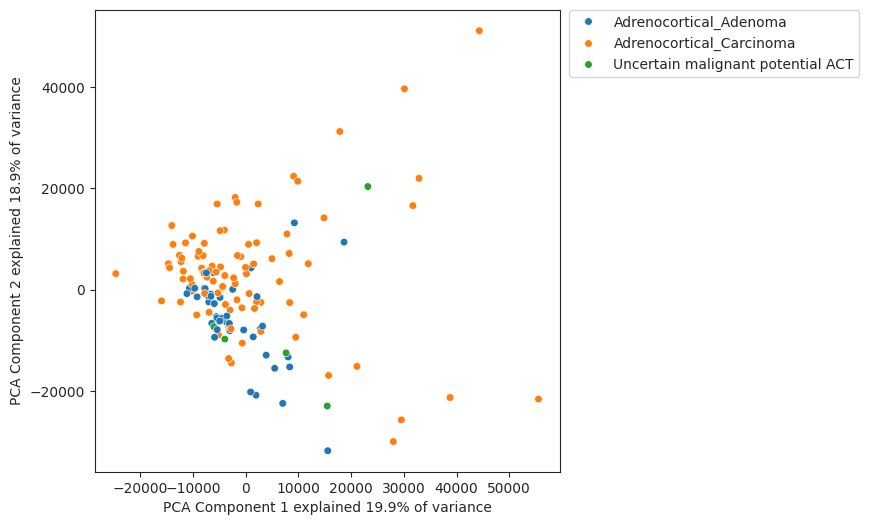

In [21]:
data = expressions['PMC9066577'].join(annotation)
columns_to_use = list(data.columns)[:list(data.columns).index('Patient')]
plot_PCA(data[columns_to_use].T, hue=list(data['Diagnosis']))

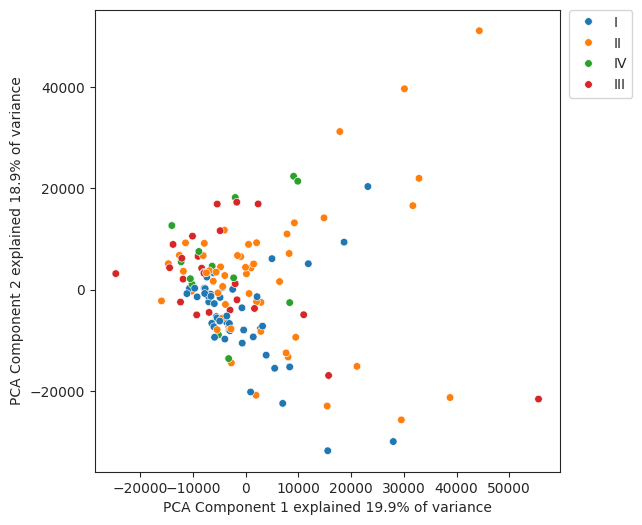

In [22]:
data = expressions['PMC9066577'].join(annotation)
columns_to_use = list(data.columns)[:list(data.columns).index('Patient')]
plot_PCA(data[columns_to_use].T, hue=list(data['Stage']))

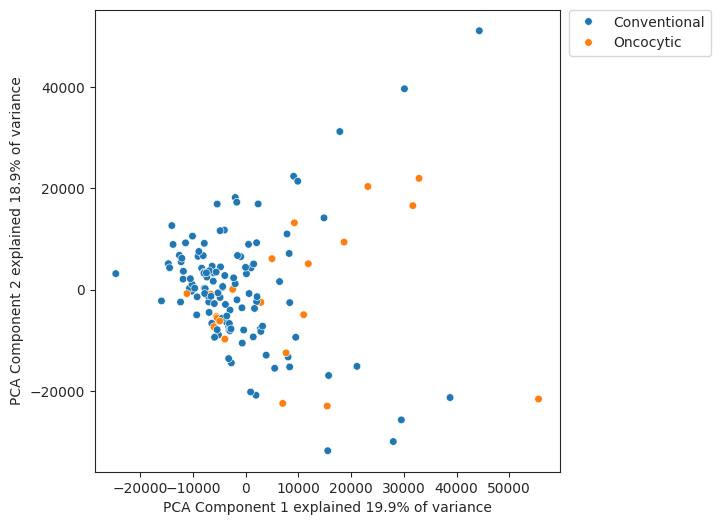

In [23]:
data = expressions['PMC9066577'].join(annotation)
columns_to_use = list(data.columns)[:list(data.columns).index('Patient')]
plot_PCA(data[columns_to_use].T, hue=list(data['Histological_type']))

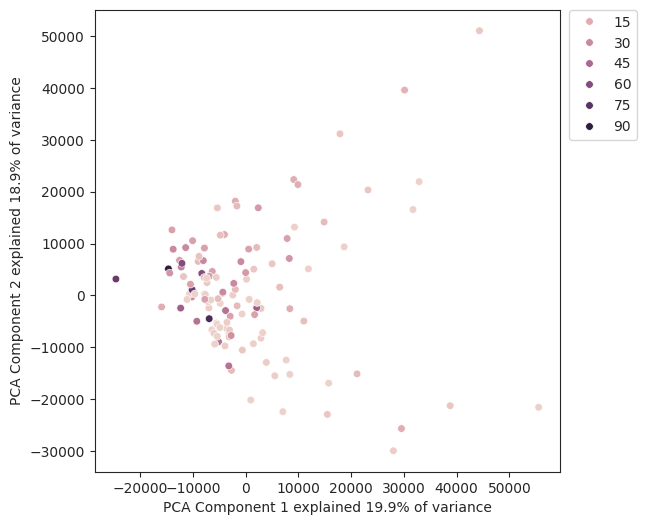

In [24]:
data = expressions['PMC9066577'].join(annotation)
columns_to_use = list(data.columns)[:list(data.columns).index('Patient')]
plot_PCA(data[columns_to_use].T, hue=list(data['Ki67']))

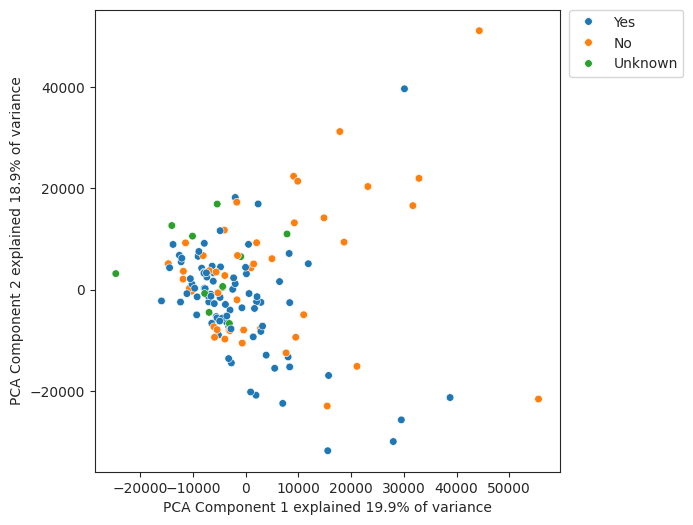

In [25]:
data = expressions['PMC9066577'].join(annotation)
columns_to_use = list(data.columns)[:list(data.columns).index('Patient')]
plot_PCA(data[columns_to_use].T, hue=list(data['Cortisol_secretion']))

**Вывод:**

Все образцы включают злокачественные опухоли, не выявлено явных кластеров по стадиям рака, а гистологический тип в основном соответствует общепринятому. Значения Ki67 score в центре кластера выше и постепенно уменьшаются по мере удаления от центра, а распределение уровня секреции кортизола также не имеет четкой тенденции.

## Task №7 (1 point)

Join all expression data into one dataframe. Keep only samples that are in the annotation, and exclude genes that filled with NA values. Print the number of resulting genes and samples. Make a PCA plot on joint data with sample coloring using the Diagnosis and Cohort columns from the annotation. Briefly describe the resultion plot and explain why the samples are grouped this way.

---
Объедените данные экспрессий в один датафрейм (не забудьте удалить гены в которых есть значения NA и убрать образцы которых нет в анотации). Сколько всего генов по которым есть данные во всех образцам? Постройте PCA-plot и покрасьте образцы с помощью колонок Diagnosis и Cohort из аннотации. Опишите групировку образцов на графиках и объясните.


Всего генов по которым есть данные во всех образцах: 14870


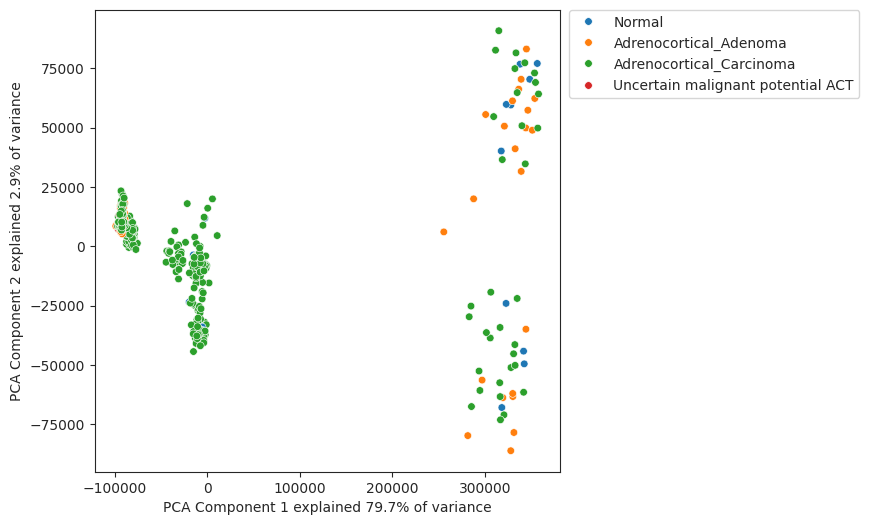

In [26]:
def preprocess_data(data, annotation):
    # Удаление строк с отсутствующими значениями
    data = data.dropna(axis=0)

    # Оставляем только те образцы, которые есть и в данных, и в аннотации
    common_samples = set(data.index).intersection(set(annotation.index))
    data = data.loc[list(common_samples)]

    return data

def merge_datasets(expressions, annotation, datasets_drive_id):
    merged_data = None
    for key in datasets_drive_id.keys():
        expression_data = expressions[key].dropna(axis=0)
        common_samples = set(expression_data.index).intersection(set(annotation.index))
        new_expression_data = expression_data.loc[list(common_samples)]
        if merged_data is None:
            merged_data = new_expression_data
        else:
            merged_data = pd.concat([merged_data, new_expression_data])

    return merged_data

def remove_duplicates(data):
    # Удаление столбцов с повторяющимися индексами
    data = data.dropna(axis=1)
    data = data[~data.index.duplicated()]
    return data

def count_genes(data):
    all_genes = data.shape[1]
    return all_genes

# Предварительная обработка данных для первого набора данных
data = expressions['GSE33371']
data = preprocess_data(data, annotation)

# Объединение данных из всех наборов данных
merged_data = merge_datasets(expressions, annotation, datasets_drive_id)

# Удаление дубликатов и подсчет генов
merged_data = remove_duplicates(merged_data)
all_genes = count_genes(merged_data)

print(f'Всего генов по которым есть данные во всех образцах: {all_genes}')

# Построение графика PCA
plot_PCA(merged_data.T, hue=list(annotation['Diagnosis']))

$\color{red}{\text{
Также не объяснена группировка + не все диагонозы. Можно исправить}}$

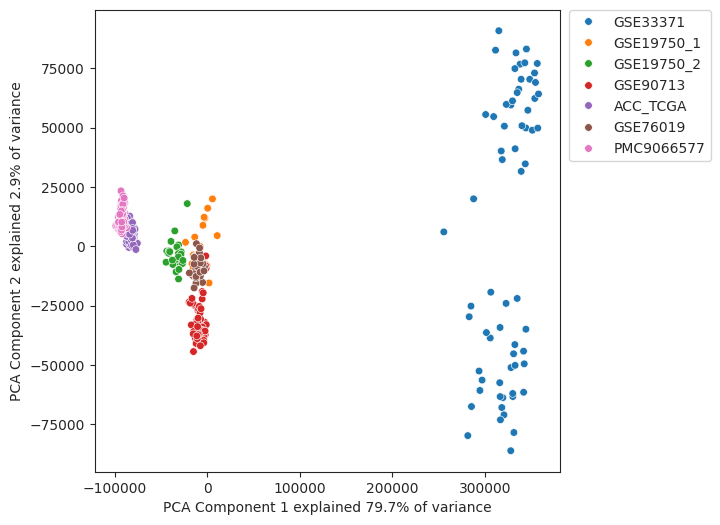

In [27]:
plot_PCA(merged_data.T, hue = list(annotation['Cohort']))

хотелось увидеть биологический батч эффект, но не получилось. В данном случае этот батч эффект связан с тем, что мы собирали данные с разных платформ, то есть это технический батч эффект

## Task №8 (1 point)
Save the expressions of all Adrenocortical carcinoma samples in a separate data frame. Calculate gene signature scores using the cacl_sign_scores function (the list of genes for each signature will be stored in the expr_signs variable after running the cell below). Transform the scores using the median_scaling function (over scores, not over samples) and plot the PCA (PC1 vs PC2) using the scores as sample properties.

---

Сохраните в отдельный датафрейм экспрессию всех образов с диагнозом Adrenocortical carcinoma. Используя функцию cacl_sign_scores, рассчитайте скоры экспрессионных сигнатур для кажлого образца (после запуска ячеек ниже, сигнатуры будут сохранены в переменной expr_signs). Отшкалируйте данные используя функцию median_scaling (по скорам, не по образцам), постройте PCA плот, используя расчитанные скоры как свойства образцов.

In [28]:
signatures_file = 'TCGA_expr_profiles.csv'
signatures_drive_id = '195vZN8IFsZ9jDsgeuool9NHI6T_axxb9'

downloaded = drive.CreateFile({'id': signatures_drive_id})
downloaded.GetContentFile(signatures_file)
sign_data = pd.read_csv(signatures_file, sep = ';', skiprows=7)

tcga_nmf_clusters = {4 : 'steroid-phenotype-low+proliferation',
1 : 'steroid-phenotype-high+proliferation',
2 : 'steroid-phenotype-low',
3 : 'steroid-phenotype-high'}

expr_signs = dict()
for f in np.unique(sign_data.loc[:,'NMF-factor']):
    expr_signs[tcga_nmf_clusters[f]] = list(sign_data.loc[sign_data['NMF-factor'] == f,:].GeneSymbol)

In [29]:
def cacl_sign_scores(data, gene_sets, rank_method='max'):
    '''
    :param data: pd.DataFrame, DataFrame with samples in columns and genes in rows
    :param gene_sets: dict, with signature names in keys and gene lists in values
    :param rank_method: str, default 'max', how to rank the group of records that have the same value,
        type in cell "??pd.DataFrame.rank" for detailes, 'method' parameter
    '''
    processes = pd.DataFrame(0, index = expr_signs.keys(), columns = data.columns)
    data_ranked = data.rank(method=rank_method, na_option='bottom')

    for gs_name in list(gene_sets.keys()):
        genes = gene_sets[gs_name]
        common_genes = list(set(genes).intersection(set(data_ranked.index)))
        if not len(common_genes):
            continue
        else:
            sranks = data_ranked.loc[common_genes,:]
            scores = (sranks**1.25).sum() / (
                sranks**0.25).sum() - (len(data_ranked.index) - len(common_genes) + 1) / 2
            processes.loc[gs_name, scores.index] = scores
    if processes.all().sum() == 0:
        print('WARNING: returning zero dataframe.')
    return processes

In [30]:
def median_scaling(df, clip=None):
    '''
    :param df : pandas.DataFrame, where rows are samples and columns are genes
    :param clip: float, default 'None', symmetrically clips the scaled data to the value
    =======================================================================================
    mad function from statsmodels.robust.scale - The Median Absolute Deviation along given axis of an array
    '''
    median = 1.0 * df.median()
    madv = 1.0 * mad(df)
    df_out = df.sub(median).div(madv)
    if clip is not None:
        return df_out.clip(-clip, clip)
    return df_out

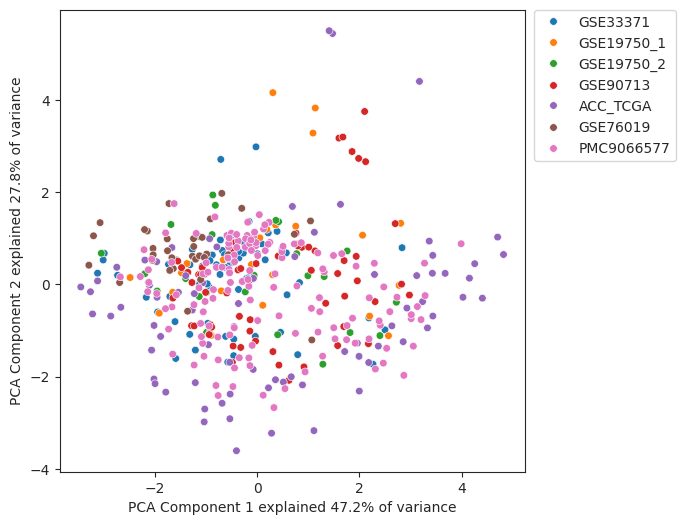

In [31]:
# Выбираем образцы аденокортикальной карциномы
adrenocortical_samples = merged_data

# Вычисляем оценки подписей
expr_signs_scores = cacl_sign_scores(adrenocortical_samples.T, expr_signs)

# Масштабируем оценки
scaled_scores = median_scaling(expr_signs_scores.T)

# Заменяем пропущенные значения на медиану
scaled_scores_median_filled = scaled_scores.fillna(scaled_scores.median())

# Строим график PCA
plot_PCA(scaled_scores_median_filled.T, hue=list(annotation['Cohort']))

$\color{red}{\text{
Также не объяснена группировка}}$

так мы устранили технический батч эффект и перемешали все наши данные

## Task №9 (2 points - 1 point for each algorithm)

Perform a cluster analysis of the dataset containig gene signatures scores using Agglomerative Clustering (Hierarchical clustering) and K-mean algorithms. Specify the number of clusters - 4 (n_clusters=4). Diaplay PCA-plot, colour samples with claster labels. <br>

Which of these algorithms is best suited for this task? (give answer based on visual inspection). For Agglomerative Clustering, try different methods for calculating the distances between samples (linkage parameter), which method shows a better result? For K-means, run a algorithm a few times and evaluate the reproducibility of the results.

---
Проведите кластерный анализ полученного в задаче 8 датаета со скорами сигнатур, используя алгоритмы Agglomerative Clustering (Иерархическая кластеризация) и K-means, n_clusters=4.  Постройте PCA plot, используя полученную разметку образцов по класетерам для раскраски образцов.

Какой из этих алгоритмов лучше выделяет кластера (дайте ответ на основании визуальной инспекции)? Для Agglomerative Clustering попробуйте различные методы расчета растояний между образцами (параметр linkage), какой метод показывает более адекваный результат? Для K-means проведите несколько повторений и оцените воспроизводимость результатов.

---

Manuals:<br>
AgglomerativeClustering https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html<br>
K-means https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html



In [32]:
from sklearn.cluster import AgglomerativeClustering, KMeans

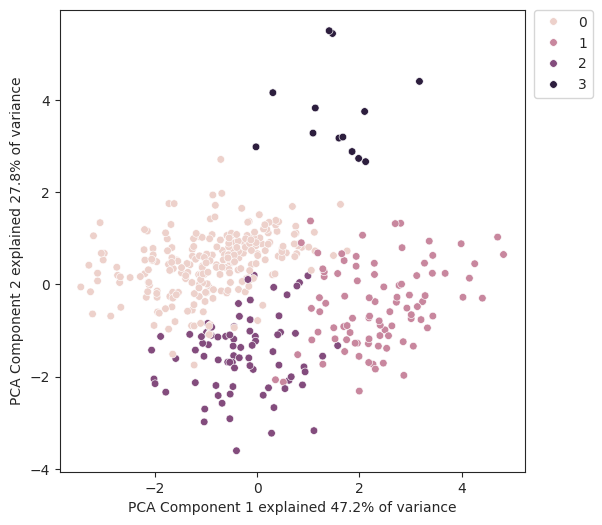

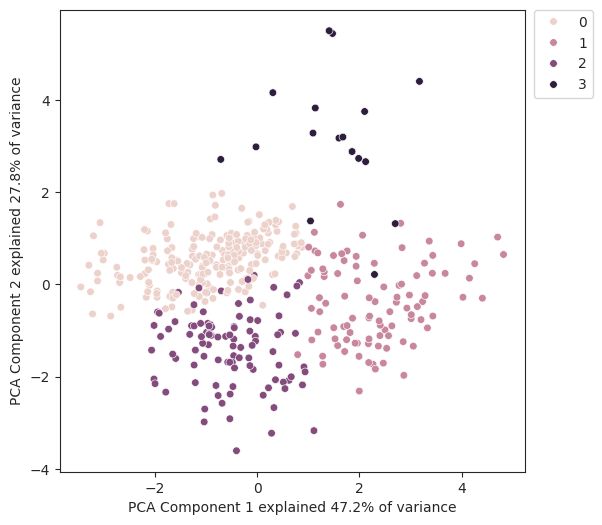

In [33]:
# Agglomerative Clustering
agglomerative_cluster = AgglomerativeClustering(n_clusters=4, linkage='ward')
agglomerative_labels = agglomerative_cluster.fit_predict(scaled_scores)

# K-means
kmeans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit_predict(scaled_scores)

plot_PCA(scaled_scores.T, hue=list(agglomerative_labels))
plot_PCA(scaled_scores.T, hue=list(kmeans_labels))

**Вывод:**

Похоже, что Agglomerative Clustering демонстрирует более стабильные и согласованные результаты. При экспериментах с изменением параметров алгоритма отмечается небольшое влияние на результаты, и наблюдается высокая степень воспроизводимости.

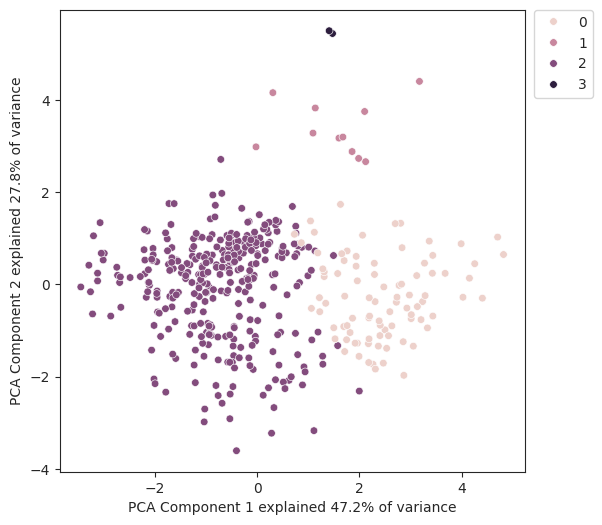

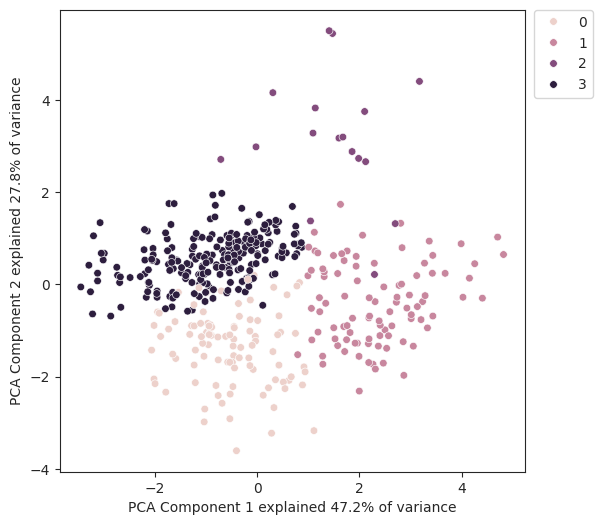

In [34]:
# Agglomerative Clustering
agglomerative_cluster = AgglomerativeClustering(n_clusters=4, linkage='average')
agglomerative_labels = agglomerative_cluster.fit_predict(scaled_scores)

# K-means
kmeans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit_predict(scaled_scores)

plot_PCA(scaled_scores.T, hue=list(agglomerative_labels))
plot_PCA(scaled_scores.T, hue=list(kmeans_labels))

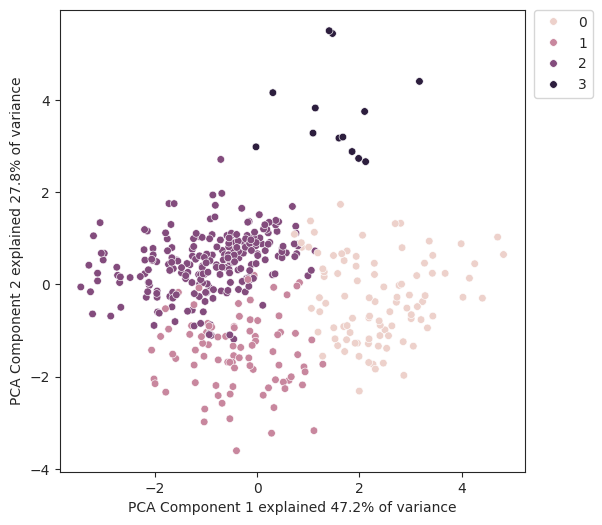

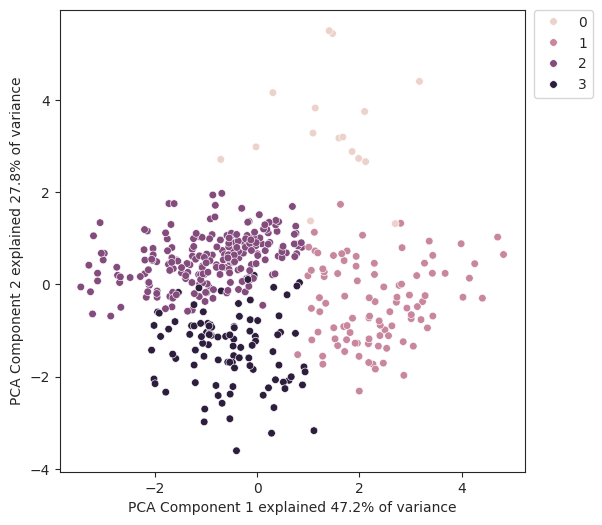

In [35]:
# Agglomerative Clustering
agglomerative_cluster = AgglomerativeClustering(n_clusters=4, linkage='complete')
agglomerative_labels = agglomerative_cluster.fit_predict(scaled_scores)

# K-means
kmeans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit_predict(scaled_scores)

plot_PCA(scaled_scores.T, hue=list(agglomerative_labels))
plot_PCA(scaled_scores.T, hue=list(kmeans_labels))

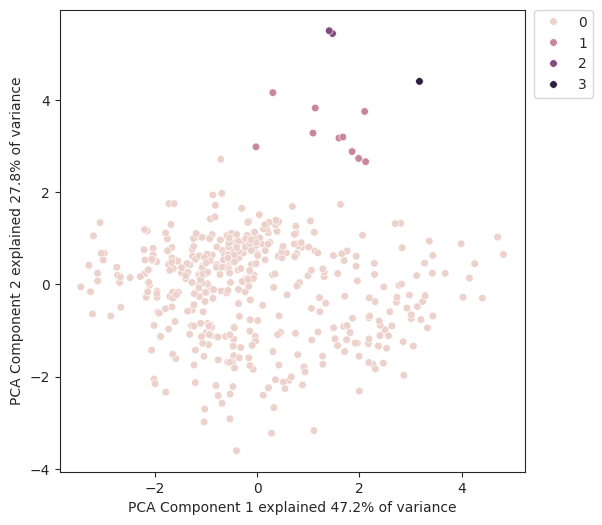

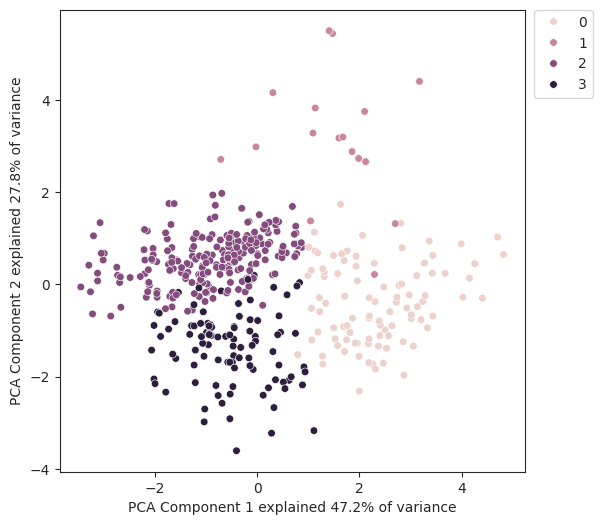

In [36]:
# Agglomerative Clustering
agglomerative_cluster = AgglomerativeClustering(n_clusters=4, linkage='single')
agglomerative_labels = agglomerative_cluster.fit_predict(scaled_scores)

# K-means
kmeans = KMeans(n_clusters=4)
kmeans_labels = kmeans.fit_predict(scaled_scores)

plot_PCA(scaled_scores.T, hue=list(agglomerative_labels))
plot_PCA(scaled_scores.T, hue=list(kmeans_labels))

$\color{red}{\text{
А удалось ли попробовать разные враинты подсчета расстояний и проверить стабильность k means? Можно добавить }}$

Видно, что выбранный параметр ward наиболее адекватно кластеризует (также неплохо сработал complete). Для k-means результаты воспроизводимы

## Task №10 (2 points)

Choose one of the clustering results that you think is the best. Here, the 4 found clusters represent 4 Adrenocortical carcinoma subtypes obtained using expression data.
* Plot Kaplan-Meier curves for each of the four subtypes using the kaplanmeier package. Use the annotation columns 'OS' (number of months under observation) and 'OS_FLAG' (occurrence of event, 1 - patient decreased, 0 - patient alive), remember to remove samples with missing values (NA). How many patients are included in this survival analysis? Which subtype is associated with the worst prognosis and which one with the best?

* Each of the 4 gene signatures characterizes one of the 4 subtypes. It is expected that the belonging of a sample to a particular subtype can be determined by the largest gene signature score (steroid-phenotype-low+proliferation, steroid-phenotype-high+proliferation, steroid-phenotype-low, steroid-phenotype-high). Based on this, determine the approximate correspondence of the obtained 4 clusters and 4 subtypes of adrenal cancer and label the curves on the Kaplan-Meier plot.
---

Выберете один из результатов кластеризации, который считаете наиболее адекватным. Четыре полученных кластера в задаче 9 это четыре подтипа Adrenocortical carcinoma, выделенных на основании экспрессионного анализа.
* Посторойте кривые Каплана-Майера для пациентов каждого из четырех подтипов используя пакет kaplanmeier. Используйте колонки из аннотации 'OS' (число месяцев под наблюденим) и 'OS_FLAG'(наступление события, 1 - пациент умер, 0 - пациент жив), не забудьте убрать образцы с пропущенными значаениями. Сколько пациентов участвуют в анализе выживаемости? Какой подтип связан с худшим прогнозом, а какой с лучшим?


* (Optional) Каждая из 4 генных сигнатур характеризует один из 4 подтипов. Ожидается, что принадлежность образца к конкретному подтипу можно определить по самому большому одноименному скору (steroid-phenotype-low+proliferation, steroid-phenotype-high+proliferation, steroid-phenotype-low, steroid-phenotype-high). На основании этого определите примерное соответствие полученных 4 кластеров и 4 подтипов рака надопчечника и подпишите кривые на графике Каплана-Майера.


---


Manual:<br>
kaplanmeier https://erdogant.github.io/kaplanmeier/pages/html/Examples.html


In [53]:
pip install kaplanmeier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 14.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d76211aaec39cd26584499dfa18621a1aaa90bf73cb4202e835d5d7fce8d4aa9
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [54]:
import kaplanmeier as km

Количество пациентов, участвующих в анализе выживаемости: 252


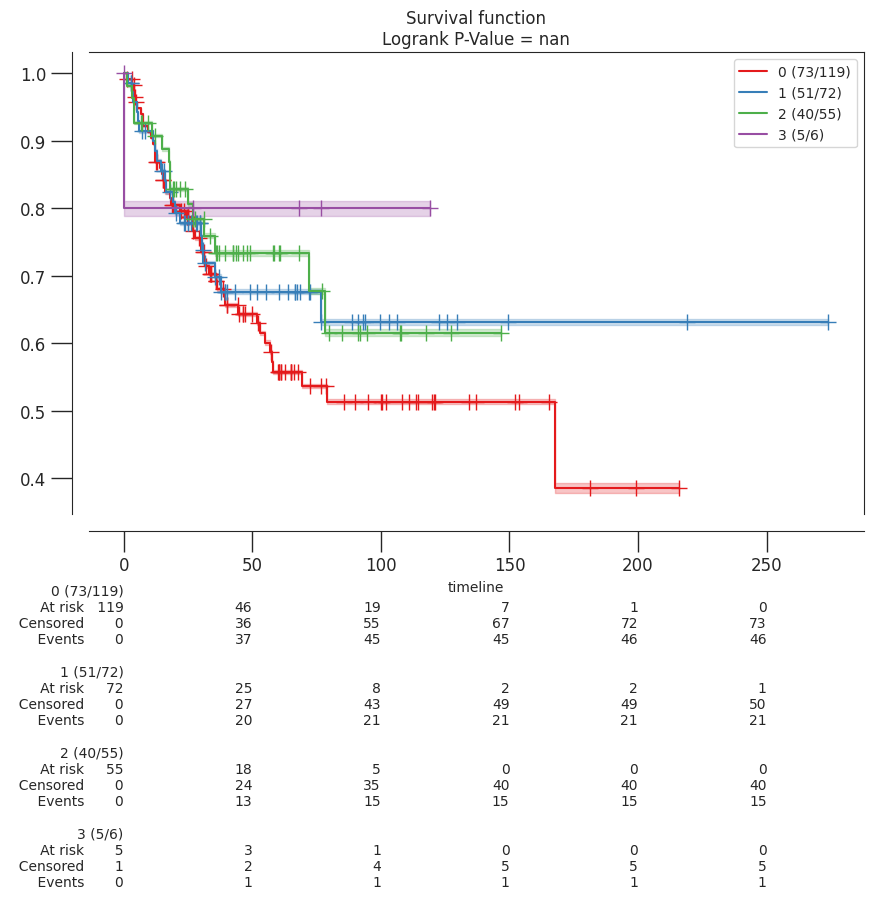

In [55]:
def filter_samples(scaled_scores, agglomerative_labels, annotation):
    # Создаем словарь меток для каждого образца
    samples_labels = {}
    for i, name in enumerate(scaled_scores.index):
        samples_labels[name] = agglomerative_labels[i]

    # Определяем общие образцы между масштабированными оценками и временем выживания
    common_samples = set(scaled_scores.index).intersection(set(annotation.index))
    new_scaled_scores = scaled_scores.loc[list(common_samples)]

    # Формируем список меток для каждого образца
    new_labels = [samples_labels[key] for key in new_scaled_scores.index]

    return new_scaled_scores, new_labels

# Очистка данных и подсчет количества пациентов
data_cleaned = annotation.dropna(subset=['OS', 'OS_FLAG'])
total_patients = len(data_cleaned)
print(f"Количество пациентов, участвующих в анализе выживаемости: {total_patients}")

# Выделение времени выживания и информации о смерти
time = data_cleaned['OS']
died = data_cleaned['OS_FLAG']

# Фильтрация образцов и меток
new_scaled_scores, new_labels = filter_samples(scaled_scores, agglomerative_labels, data_cleaned)

# Compute Survival
results = km.fit(time, died, new_labels)

# Plot
km.plot(results)

**Вывод:**

График показывает, что первый подтип в основном имеет низкую выживаемость, второй подтип - высокую, а третий подтип - высокую, но с недостаточным объемом данных для полной оценки. Второй подтип характеризуется наилучшей выживаемостью.

$\color{red}{\text{
Хорошая работа, удобно читать из-за использования функций! Молодец}}$